Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16 

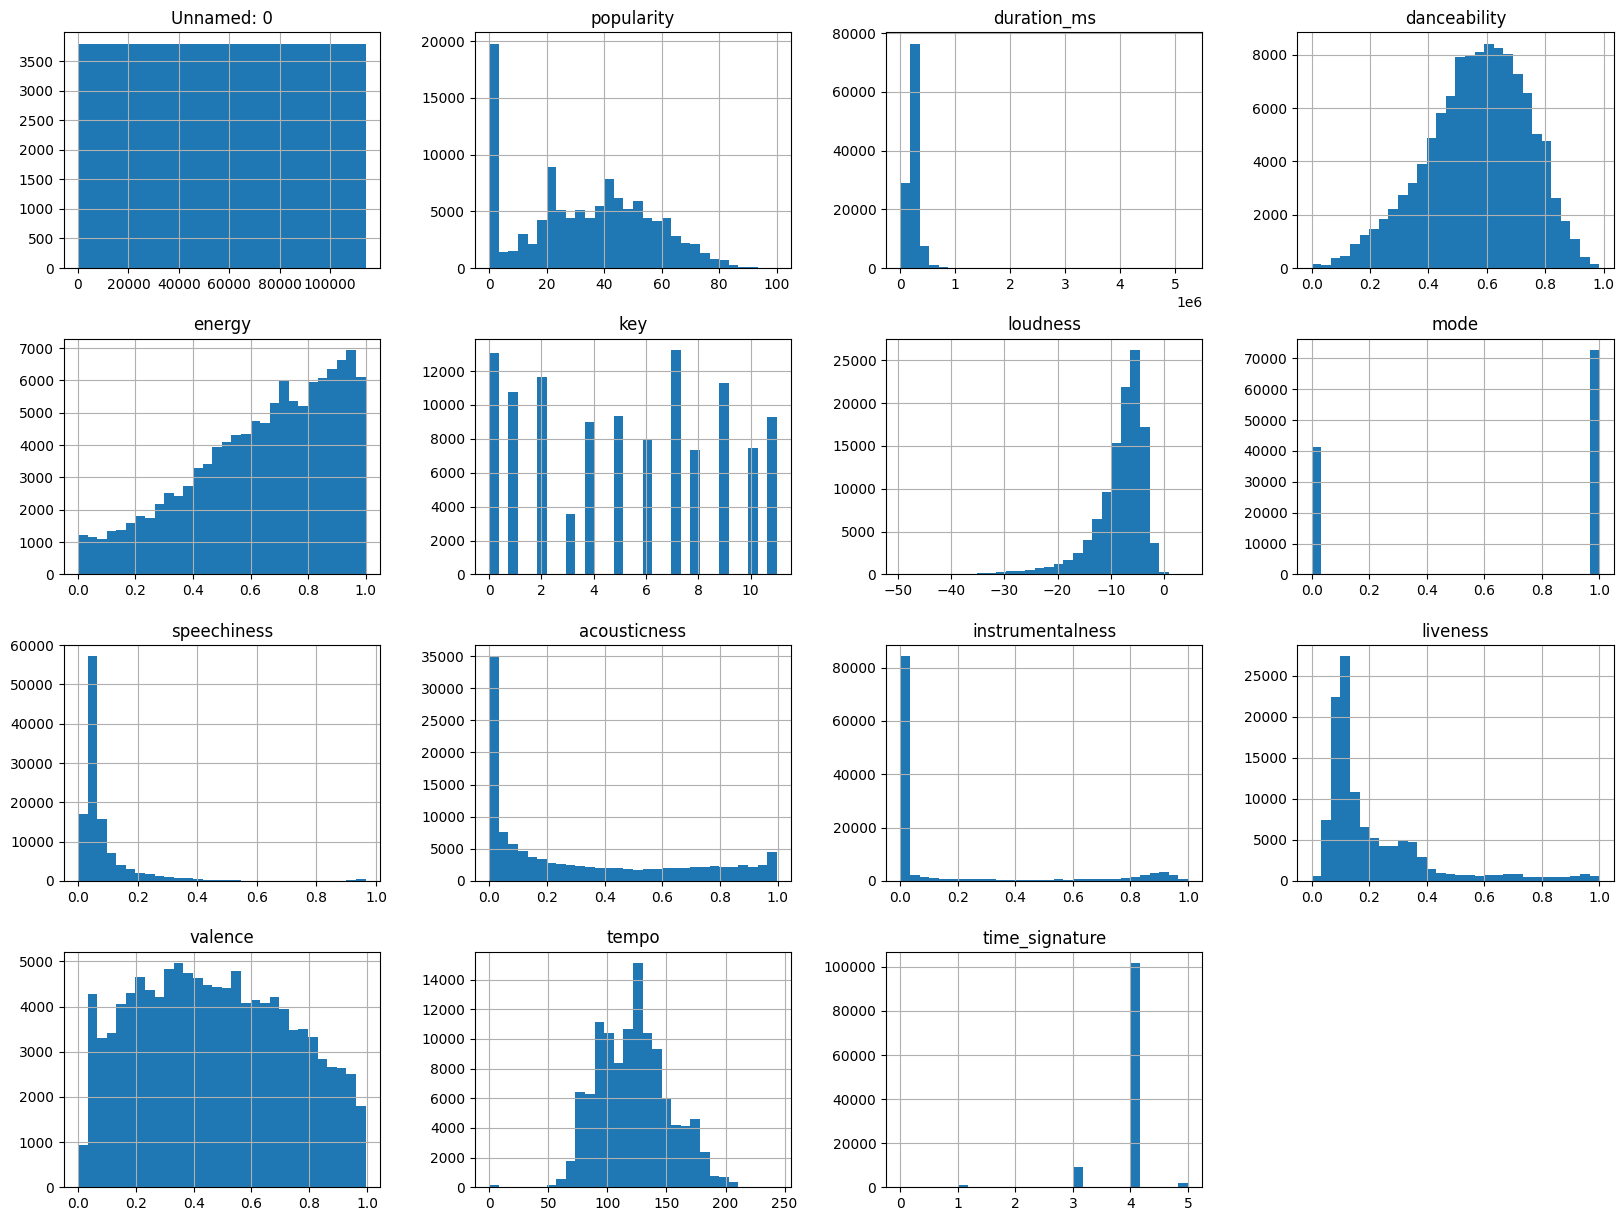


Корреляционная матрица:


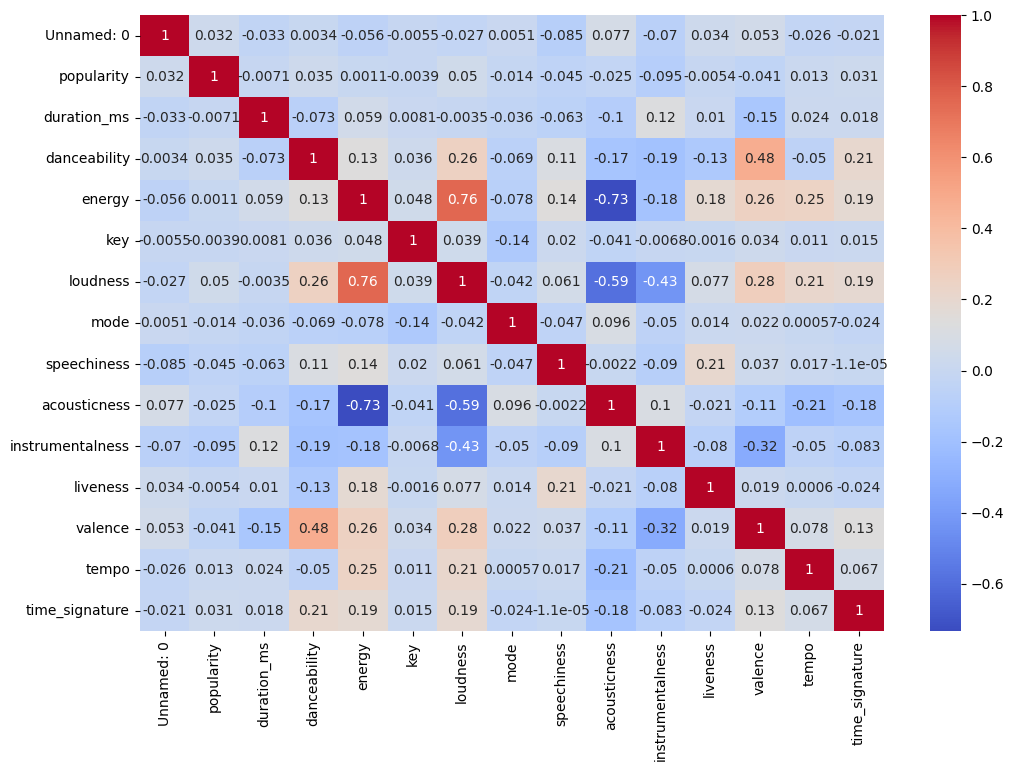


Корреляция с таргетом (popularity):
popularity          1.000000
loudness            0.050423
danceability        0.035448
Unnamed: 0          0.032142
time_signature      0.031073
tempo               0.013205
energy              0.001056
key                -0.003853
liveness           -0.005387
duration_ms        -0.007101
mode               -0.013931
acousticness       -0.025472
valence            -0.040534
speechiness        -0.044927
instrumentalness   -0.095139
Name: popularity, dtype: float64

Создание новых признаков:

Корреляция новых признаков с таргетом:
                     energy_danceability  loudness_valence  tempo_speechiness  \
energy_danceability             1.000000          0.061664           0.156801   
loudness_valence                0.061664          1.000000           0.004353   
tempo_speechiness               0.156801          0.004353           1.000000   
popularity                      0.006060          0.064209          -0.040012   

                     p

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Загрузка данных
df = pd.read_csv('dataset.csv')

# Первичный анализ данных
print("Информация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())
print("\nПропущенные значения:")
print(df.isnull().sum())

# Заполнение пропущенных значений (если есть) только для числовых столбцов
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Гистограммы для числовых признаков
print("\nГистограммы числовых признаков:")
df[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.show()

# Корреляционная матрица
print("\nКорреляционная матрица:")
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Корреляция с таргетом (предположим, что таргет - это 'popularity')
print("\nКорреляция с таргетом (popularity):")
target_corr = corr_matrix['popularity'].sort_values(ascending=False)
print(target_corr)

# Feature Engineering
print("\nСоздание новых признаков:")
df['energy_danceability'] = df['energy'] * df['danceability']
df['loudness_valence'] = df['loudness'] * df['valence']
df['tempo_speechiness'] = df['tempo'] * df['speechiness']

# Проверка корреляции новых признаков с таргетом
print("\nКорреляция новых признаков с таргетом:")
new_features_corr = df[['energy_danceability', 'loudness_valence', 'tempo_speechiness', 'popularity']].corr()
print(new_features_corr)

# Обработка категориальных признаков
print("\nОбработка категориальных признаков:")
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Подготовка данных
X = df.drop(columns=['popularity'])
y = df['popularity']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модель для определения важности признаков
print("\nВажность признаков:")
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Линейная регрессия
print("\nЛинейная регрессия:")
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-lin_scores)
print("Linear Regression RMSE:", lin_rmse_scores.mean())

# Дерево решений
print("\nДерево решений:")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
tree_rmse_scores = np.sqrt(-tree_scores)
print("Decision Tree RMSE:", tree_rmse_scores.mean())

# Настройка гиперпараметров для XGBoost
print("\nНастройка гиперпараметров для XGBoost:")
xgb_reg = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("Лучшие параметры для XGBoost:", grid_search.best_params_)

# Градиентный бустинг с лучшими параметрами
print("\nГрадиентный бустинг с лучшими параметрами:")
xgb_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse_scores = np.sqrt(-xgb_scores)
print("XGBoost RMSE:", xgb_rmse_scores.mean())

# Нейронная сеть
print("\nНейронная сеть:")
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))  # Добавляем Dropout для регуляризации
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Обучение нейронной сети
nn_model = build_model()
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Оценка нейронной сети
nn_pred = nn_model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
print("Neural Network RMSE:", nn_rmse)

# Ансамбль моделей
print("\nАнсамбль моделей:")
ensemble = VotingRegressor(estimators=[
    ('xgb', best_xgb),
    ('tree', DecisionTreeRegressor(max_depth=5, random_state=42)),
    ('linear', LinearRegression())
])
ensemble.fit(X_train, y_train)

# Оценка ансамбля на тестовых данных
y_pred = ensemble.predict(X_test)
print("\nОценка ансамбля на тестовых данных:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# Визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('График предсказаний vs истинных значений')
plt.show()

# Выводы по результатам
print("\nВыводы по результатам:")
print("1. Линейная регрессия показала среднюю производительность с RMSE:", lin_rmse_scores.mean())
print("2. Дерево решений показало RMSE:", tree_rmse_scores.mean())
print("3. XGBoost с лучшими параметрами показал RMSE:", xgb_rmse_scores.mean())
print("4. Нейронная сеть показала RMSE:", nn_rmse)
print("5. Ансамбль моделей показал наилучшие результаты с MAE:", mean_absolute_error(y_test, y_pred), "и R²:", r2_score(y_test, y_pred))
print("6. На основе анализа можно сделать вывод, что ансамбль моделей является наиболее эффективным подходом для данной задачи.")